In [1]:
import os, sys
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pickle
from tqdm import tqdm

from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.signal import medfilt

import utils2p

In [2]:
from twoppp import load, pipeline, utils, rois
from twoppp import plot as myplt
from twoppp.pipeline import PreProcessParams
params = PreProcessParams()

2022-08-30 18:03:12.622392: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


# 1. Enter the directory of the fly for which you want to select ROIs in the cell below

In [3]:
fly_dir = "/mnt/NAS2/JB/220818_DfdxGCaMP6s_tdTom/Fly2"
fly_processed_dir = os.path.join(fly_dir, load.PROCESSED_FOLDER)
trial_dirs = load.get_trials_from_fly(fly_dir, contains="xz")[0]
processed_dirs = utils.list_join(trial_dirs, load.PROCESSED_FOLDER)
processed_dirs

['/mnt/NAS2/JB/220818_DfdxGCaMP6s_tdTom/Fly2/001_xz/processed',
 '/mnt/NAS2/JB/220818_DfdxGCaMP6s_tdTom/Fly2/002_xz/processed',
 '/mnt/NAS2/JB/220818_DfdxGCaMP6s_tdTom/Fly2/003_xz/processed',
 '/mnt/NAS2/JB/220818_DfdxGCaMP6s_tdTom/Fly2/004_xz/processed']

### this cell loads the summary stats and the pca maps that you should have pre-computed using the SummaryStatsTask and ROISelectionTask

In [4]:
summary_stats_file = os.path.join(fly_processed_dir, params.summary_stats)
pca_map_file = os.path.join(fly_processed_dir, params.pca_maps)
with open(summary_stats_file, "rb") as f:
    summary_stats = pickle.load(f)
print(list(summary_stats.keys()))
with open(pca_map_file, "rb") as f:
    pca_data = pickle.load(f)
print(list(pca_data.keys()))

['dff_means', 'dff_mean_diffs', 'green_means', 'green_mean_diffs', 'green_means_raw', 'green_mean_diffs_raw', 'dff_stds', 'dff_std_diffs', 'green_stds', 'green_std_diffs', 'green_stds_raw', 'green_std_diffs_raw', 'dff_quants', 'dff_quant_diffs', 'green_quants', 'green_quant_diffs', 'green_quants_raw', 'green_quant_diffs_raw', 'dff_local_corrs', 'dff_local_corr_diffs', 'green_local_corrs', 'green_local_corr_diffs', 'green_local_corrs_raw', 'green_local_corr_diffs_raw', 'trials', 'ref_trial']
['green_std', 'mask', 'i_samples', 'green_pixels_z', 'green_pixel_means', 'green_pixel_stds', 'v_pca', 'pca_maps']


### now perform automated peak detection on the standard deviation projection

In [6]:
local_peak_std = peak_local_max(np.log10(pca_data["green_std"]), min_distance=5, threshold_abs=0.001)

### initialise the data structures into which you will later save your selected ROIs

In [7]:
# numbers of peaks in standard deviation image as shown on the left of the plot below
std_confirmed_rois = []
# numbers of peaks in standard deviation image as shown on the right of the plot below
# max_confirmed_rois = []
# numbers of peaks in local correlation image as shown on the bottom of the notebook
# corr_confirmed_rois = []
# y and x coordinates of additional rois as [y, x], i.e. a list of lists: [[y1, x1], [y2, x2]]
additional_rois = [[0,0]]

confirmed_rois = np.vstack((local_peak_std[std_confirmed_rois, :], 
                            # local_peak_max[max_confirmed_rois, :], 
                            # local_peak_corr[corr_confirmed_rois, :], 
                            additional_rois))
print("Number of confirmed ROIs: {}".format(len(confirmed_rois)))

Number of confirmed ROIs: 1


# 2. Run this cell to display your data and the proposed peaks <br>
you can use the zoom in function of the interactive plot to have a more detailled look at individual neurons <br>
The process for confirming a ROI is as follows:
1. If you are happy with a specific ROI suggested by the peak finder, remember its number and enter it into the "std_confirmed_rois" list in the cell below (under 3.)
2. If you are not happy, Zoom in as much as you can on a particular ROI. Then hover over the "Std across trials" plot. In the bottom right corner, you will see the current coordinates. Enter those in the "additional_rois" list in the cell below (under 3.).
3. Regularily run the cell below (under 3.) and then run the plotting cell again to refresh the already confirmed ROIs. You will see the confirmed ROIs in green

<IPython.core.display.Javascript object>


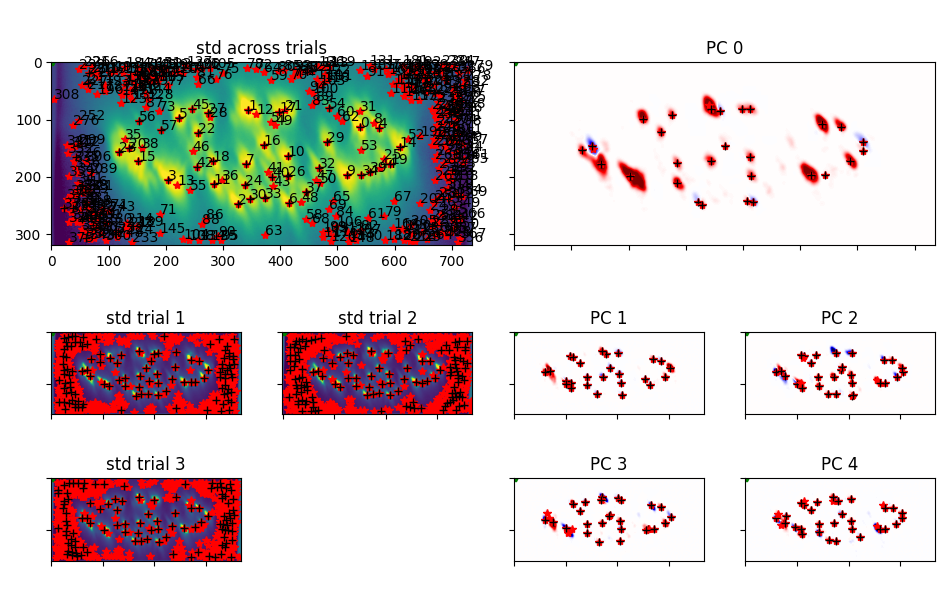

In [8]:
%matplotlib notebook
quantile = 0.99
SHOW_MAX = True
CONFIRMED = True

fig = plt.figure(figsize=(9.5, 6))  # contstained_layout=True)
layout = """
    AABB
    AABB
    CDEF
    GHIJ
    """
#    GHIJ

axs_names = "ABCDEFGHIJ"   # GHIJ"
ax_dict = fig.subplot_mosaic(layout)  # , sharex=True, sharey=True)
for i_ax, ax_name in enumerate(axs_names):
    if i_ax:
        ax_dict[ax_name].set_xticklabels([])
        ax_dict[ax_name].set_yticklabels([])
        ax_dict[axs_names[0]].get_shared_x_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
        ax_dict[axs_names[0]].get_shared_y_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
        

for i_ax, ax_name in enumerate(axs_names):
    ax = ax_dict[axs_names[i_ax]]
    if i_ax == 0:
        im = np.log10(pca_data["green_std"])
        title = "std across trials"
        this_cmap = plt.cm.get_cmap("viridis")
        this_clim = [np.quantile(im, 1-quantile), np.quantile(im, quantile)]
        i_col = 0
    elif i_ax == 1:
        im = gaussian_filter(pca_data["pca_maps"][0], sigma=3)
        title = "PC 0"
        this_cmap = plt.cm.get_cmap("seismic")
        this_clim = [-1e-2, 1e-2]  # -np.quantile(im, quantile), np.quantile(im, quantile)]
        i_col = 2
    else:
        i_row = (i_ax - 2) // 4
        i_col = (i_ax - 2) % 4
        if i_col < 2:  # target all the left small subplots
            i_trial = i_row * 2 + i_col
            try:
                im = np.log10(summary_stats["green_stds"][i_trial])
            except:
                ax.axis("off")
                continue
            title = "std trial {}".format(i_trial + 1)
            this_cmap = plt.cm.get_cmap("viridis")
            this_clim = [np.quantile(im, 1-quantile), np.quantile(im, quantile)]
        else:
            i_trial = i_row * 2 + i_col - 2
            im = gaussian_filter(pca_data["pca_maps"][i_trial+1], sigma=3)
            title = "PC {}".format(i_trial + 1)
            this_cmap = plt.cm.get_cmap("seismic")
            this_clim = [-1e-2, 1e-2]  # -np.quantile(im, quantile), np.quantile(im, quantile)]
    ax.imshow(im, clim=this_clim, cmap=this_cmap)
    ax.set_title(title)
    # ax.set_xlim([60, 645])
    # ax.set_ylim([285, 30])
    
    if SHOW_MAX:
        
        if i_ax == 0:
            coordinates5 = local_peak_std
        else:
            coordinates5 = peak_local_max(im, min_distance=5, threshold_abs=0.001)
        coordinates10 = peak_local_max(im, min_distance=10, threshold_abs=0.001)
        if i_ax == 1 or i_col >= 2:
            coordinates5_min = peak_local_max(-im, min_distance=5, threshold_abs=0.001)
            coordinates10_min = peak_local_max(-im, min_distance=10, threshold_abs=0.001)
            _ = [ax.plot(pixel[1], pixel[0], 'r*') for pixel in coordinates5_min]
            _ = [ax.plot(pixel[1], pixel[0], 'k+') for pixel in coordinates10_min]
        _ = [ax.plot(pixel[1], pixel[0], 'r*') for pixel in coordinates5]
        _ = [ax.plot(pixel[1], pixel[0], 'k+') for pixel in coordinates10]
        if i_ax == 0:
            for i in range(len(coordinates5)):
                ax.annotate(str(i), np.flip(coordinates5[i]))
            
        
    if CONFIRMED:
        _ = [ax.plot(pixel[1], pixel[0], 'gp') for pixel in confirmed_rois]
    
fig.tight_layout()

# 3. Run these cells to save the coordinates of your selected ROIs to file.

In [120]:
std_confirmed_rois = [1,2,99,104]
additional_rois = [(500,300), (573, 183)]  # format: (y, x) coordinates of additional ROIs

confirmed_rois = np.vstack((local_peak_std[std_confirmed_rois, :], 
                            # local_peak_max[max_confirmed_rois, :], 
                            # local_peak_corr[corr_confirmed_rois, :], 
                            additional_rois))
print("Number of confirmed ROIs: {}".format(len(confirmed_rois)))

Number of confirmed ROIs: 45


In [122]:
fly_processed_dir

'/mnt/NAS2/JB/220719_DfdxGCaMP6s_tdTom/Fly1/processed'

In [123]:
roi_out_dir = os.path.join(fly_processed_dir, params.roi_centers)
rois.write_roi_center_file(confirmed_rois, roi_out_dir)